# Includes:

In [1]:
%reload_ext autoreload
%autoreload 2
import tensorflow as tf
from tensorflow import keras
import numpy as np
import seaborn as sn
import os
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from data_paths import get_file_paths_ordered
from tf_lite_conversion import convert_to_tf_lite, eval_tf_lite_model
from scipy.io import wavfile
from IPython.display import Audio
from pre_process import choose_tot_slice_len, get_data_tensors, compute_mfccs
from models import get_model

In [27]:
NB_SPEAKERS = 5
dataset_percentage = 1 # 0.85
segmentLength=1024
print("Number of speakers : ", NB_SPEAKERS)

CSV_DIR = 'csv/'
MODEL_NAME =  str(NB_SPEAKERS) + '_qkeras'
TFLITE_MODEL_NAME = 'tflite_'+ MODEL_NAME[:-3]
C_MODEL_NAME = MODEL_NAME[:-3]

MODEL_DIR = 'Models/' + MODEL_NAME + '/'
# Create model directory
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)
print("Model folder : ", MODEL_DIR)
print("Model names : ", MODEL_NAME,TFLITE_MODEL_NAME, C_MODEL_NAME)

Number of speakers :  5
Model folder :  Models/5_qkeras/
Model names :  5_qkeras tflite_5_qke 5_qke


Read data:

In [3]:
paths_train, paths_test, y_train_l, y_test_l, all_paths_l  = get_file_paths_ordered(num_speaker = NB_SPEAKERS, 
                                                                                    test_ratio = 0.2,
                                                                                    balanced_dataset = True)

Total number of speakers in the original dataset: 20
Number of speakers that will be used for training:5 => 25.0%
Original number of files:  3306
Training number of files : 2260 => 68.36055656382335%


In [4]:
slice_len, durations = choose_tot_slice_len(paths=all_paths_l)

segmentLength = 1024

f_s, x_train, y_train, x_test, y_test = get_data_tensors(paths_train=paths_train, paths_test=paths_test, 
                                                         y_train_l=y_train_l, y_test_l=y_test_l,
                                                         tot_slice_len=slice_len,
                                                         used_train_sz_rat=dataset_percentage, 
                                                         used_test_sz_rat=1.,
                                                         segmentLength=segmentLength)

print("Train - test size : ", x_train.shape, x_test.shape)

Visualization of the samples ...


100%|██████████| 566/566 [00:00<00:00, 1462.07it/s]


Train - test size :  (2260, 171, 1024) (566, 171, 1024)


In [5]:
# play a random sample
i=1
fs_i, audio_data_i = wavfile.read(paths_train[i])
display(Audio(audio_data_i, rate=fs_i))

# Pre-Processing:

In [6]:
f_low=80.
f_up=7600.
num_mel_bins=80
num_mfcc=13

with tf.device("/cpu:0"):
    x_train_mfcc = compute_mfccs(x_train, frame_length=segmentLength, sample_rate=f_s, 
                                lower_edge_hertz=f_low, upper_edge_hertz=f_up,
                                num_mel_bins=num_mel_bins, num_mfcc=num_mfcc)
    x_test_mfcc  = compute_mfccs(x_test, frame_length=segmentLength, sample_rate=f_s, 
                                lower_edge_hertz=f_low, upper_edge_hertz=f_up,
                                num_mel_bins=num_mel_bins, num_mfcc=num_mfcc)

In [14]:
train_set = x_train_mfcc
test_set = x_test_mfcc
print(train_set.shape)

(2260, 171, 13, 1)


# Teacher Model:

In [16]:
model_idx = 0
input_shape = train_set.shape
teacher = get_model(input_shape=input_shape, nb_classes=NB_SPEAKERS, model_idx=model_idx)
teacher.build(input_shape=input_shape)
teacher.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_2 (Normalizat  (2260, 171, 13, 1)       3         
 ion)                                                            
                                                                 
 conv2d_4 (Conv2D)           (2260, 171, 13, 3)        30        
                                                                 
 batch_normalization_8 (Batc  (2260, 171, 13, 3)       12        
 hNormalization)                                                 
                                                                 
 activation_6 (Activation)   (2260, 171, 13, 3)        0         
                                                                 
 conv2d_5 (Conv2D)           (2260, 86, 7, 16)         448       
                                                                 
 batch_normalization_9 (Batc  (2260, 86, 7, 16)       

In [19]:
batchSize = 32 #8 # nb of togetherly processed segments(of 1024 samples each) 
epochs = 150 #40 # nb of back propagations
loss_fct = 'sparse_categorical_crossentropy'

teacher.compile(
    loss=loss_fct, 
    optimizer=tf.keras.optimizers.Adam(), 
    metrics=['accuracy']
)

callbacks = [
    keras.callbacks.ModelCheckpoint(MODEL_DIR + MODEL_NAME + '_keras_teacher.h5',save_best_only=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=20, min_lr=1.0e-5),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, verbose=1),       
]

history= teacher.fit(
    x=train_set, 
    y=y_train, 
    batch_size=batchSize, 
    epochs=epochs, 
    validation_split=0.2,
    callbacks = callbacks
)

Epoch 1/150
57/57 [==============================] - 4s 53ms/step - loss: 0.3303 - accuracy: 0.8805 - val_loss: 3.4188 - val_accuracy: 0.3761 - lr: 0.0010
Epoch 2/150
57/57 [==============================] - 3s 50ms/step - loss: 0.2721 - accuracy: 0.8982 - val_loss: 5.5052 - val_accuracy: 0.2257 - lr: 0.0010
Epoch 3/150
57/57 [==============================] - 2s 40ms/step - loss: 0.2372 - accuracy: 0.9165 - val_loss: 3.9898 - val_accuracy: 0.3562 - lr: 0.0010
Epoch 4/150
57/57 [==============================] - 3s 46ms/step - loss: 0.2181 - accuracy: 0.9154 - val_loss: 5.9257 - val_accuracy: 0.2389 - lr: 0.0010
Epoch 5/150
57/57 [==============================] - 3s 49ms/step - loss: 0.1979 - accuracy: 0.9209 - val_loss: 3.8664 - val_accuracy: 0.4226 - lr: 0.0010
Epoch 6/150
57/57 [==============================] - 2s 32ms/step - loss: 0.1932 - accuracy: 0.9159 - val_loss: 3.1361 - val_accuracy: 0.4226 - lr: 0.0010
Epoch 7/150
57/57 [==============================] - 2s 28ms/step - lo

In [20]:
y_pred = teacher.predict(test_set)

test_loss, test_acc = teacher.evaluate(test_set,  y_test, verbose=2)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

18/18 [==============================] - 0s 7ms/step
18/18 - 0s - loss: 0.1839 - accuracy: 0.9452 - 129ms/epoch - 7ms/step
Test accuracy: 0.945229709148407
Test loss: 0.18394258618354797


In [7]:
# Show the model size for Keras model 
model_save_path = MODEL_DIR + MODEL_NAME + '_keras_teacher.h5'
model = tf.keras.models.load_model(model_save_path)
h5_in_kb = os.path.getsize(model_save_path) / 1024
print("QKeras Model file : ", model_save_path)
print("QKeras Model size without quantization: %d KB" % h5_in_kb)

QKeras Model file :  Models/5_qkeras/5_qkeras_keras_teacher.h5
QKeras Model size without quantization: 383 KB


# QKeras Model

In [9]:
from qkeras import *
from tensorflow.keras import layers, regularizers

In [10]:
def get_qmodel(input_shape, nb_classes):

    model = tf.keras.models.Sequential()
    #Normalize data
    model.add(layers.Normalization())

    model.add(QConv2D(filters=3, kernel_size=(3,3), padding="same", input_shape=input_shape,
                      kernel_quantizer="quantized_bits(8, 7, alpha=1)", 
                      use_bias = False, # less parameters ? 
                      name="conv2d_1"))
    model.add(layers.BatchNormalization())
    model.add(QActivation("quantized_relu(2)", name="act_1"))

    model.add(QConv2D(filters=16, kernel_size=(3,3), strides=(2,2), padding='same',
                      kernel_quantizer="binary(alpha=1)", 
                      use_bias = False,     
                      name="conv2d_2"))    
    model.add(layers.BatchNormalization())
    model.add(QActivation("quantized_relu(2)", name="act_2"))

    model.add(layers.MaxPool2D((2,2)))

    model.add(QConv2D(filters=32, kernel_size=(3,3), strides=(2,2), padding='same',
                      kernel_quantizer="quantized_bits(8, 7, alpha=1)", 
                      use_bias = False, # less parameters ? 
                      name="conv2d_3"))
    model.add(layers.BatchNormalization())
    model.add(QActivation("quantized_relu(2)", name="act_3"))

    model.add(layers.MaxPool2D((2,2)))

    model.add(QConv2D(filters=64, kernel_size=(3,3), strides=(2,2), padding='same',
                      kernel_quantizer="quantized_bits(8, 7, alpha=1)", 
                      use_bias = False, # less parameters ? 
                      name="conv2d_4"))
    model.add(layers.BatchNormalization())
    model.add(QActivation("quantized_relu(2)", name="act_4"))

    model.add(layers.GlobalAveragePooling2D())

    model.add(layers.Flatten())

    model.add(QDense(8, kernel_regularizer=(regularizers.l1(0)),
                     kernel_quantizer="binary(alpha=1)",
                     bias_quantizer="binary(alpha=1)",
                     name="dense_1"))
    model.add(QActivation("quantized_relu(2)", name="act_5"))

    model.add(QDense(nb_classes,
                     kernel_quantizer="binary(alpha=1)",
                     bias_quantizer="binary(alpha=1)",
                     name="dense_2"))  # Nb classes to recognize
    model.add(Activation("softmax", name="softmax"))  # Softmax to get probas of each class
    

    return model

In [28]:
qmodel = get_qmodel(train_set.shape, NB_SPEAKERS)
qmodel.build(input_shape=train_set.shape)
qmodel.summary()

c:\Users\emili\anaconda3\envs\ml\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer HeNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_5 (Normalizat  (2260, 171, 13, 1)       3         
 ion)                                                            
                                                                 
 conv2d_1 (QConv2D)          (2260, 171, 13, 3)        27        
                                                                 
 batch_normalization_20 (Bat  (2260, 171, 13, 3)       12        
 chNormalization)                                                
                                                                 
 act_1 (QActivation)         (2260, 171, 13, 3)        0         
                                                                 
 conv2d_2 (QConv2D)          (2260, 86, 7, 16)         432       
                                                                 
 batch_normalization_21 (Bat  (2260, 86, 7, 16)       

Compile the model and Fit the Data:\
@TODO use weights giving the highest accuracy on the validation dataset

In [51]:
qmodel.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=tf.keras.optimizers.Adam(), 
    metrics=['accuracy']
)

model_save_path = MODEL_DIR + MODEL_NAME + '_qkeras_student.h5'
callbacks = [
    keras.callbacks.ModelCheckpoint(model_save_path,save_best_only=True,verbose=1),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=15, min_lr=1.0e-5,verbose=1),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=40, verbose=1),       
]

history = qmodel.fit(
    x = train_set, 
    y = y_train, 
    validation_split=0.2,
    callbacks = callbacks, 
    batch_size = 32, 
    epochs = 300
)

Epoch 1/300


KeyboardInterrupt: 

Evaluate the performance on the test set:

In [14]:
y_pred = qmodel.predict(test_set)

test_loss, test_acc = qmodel.evaluate(test_set,  y_test, verbose=1)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

18/18 [==============================] - 1s 25ms/step - loss: 1.3503 - accuracy: 0.4982
Test accuracy: 0.49823322892189026
Test loss: 1.3502572774887085


In [73]:
print_qstats(qmodel)

Instructions for updating:
Use ref() instead.


Instructions for updating:
Use ref() instead.



Number of operations in model:
    conv2d_1                      : 60021 (smult_8_8)
    conv2d_2                      : 260064 (smux_1_2)
    conv2d_3                      : 202752 (smult_8_2)
    conv2d_4                      : 110592 (smult_8_2)
    dense_1                       : 512   (smux_1_2)
    dense_2                       : 40    (smux_1_2)

Number of operation types in model:
    smult_8_2                     : 313344
    smult_8_8                     : 60021
    smux_1_2                      : 260616

Weight profiling:
    conv2d_1_weights               : 27    (8-bit unit)
    conv2d_1_bias                  : 0     (32-bit unit)
    conv2d_2_weights               : 432   (1-bit unit)
    conv2d_2_bias                  : 0     (32-bit unit)
    conv2d_3_weights               : 4608  (8-bit unit)
    conv2d_3_bias                  : 0     (32-bit unit)
    conv2d_4_weights               : 18432 (8-bit unit)
    conv2d_4_bias                  : 0     (32-bit unit)
    dens

In [88]:
# Show the model size for QKeras model 
model_save_path = os.path.join(model_save_path)
h5_in_kb = os.path.getsize(model_save_path) / 1024
print("QKeras Model file : ", model_save_path)
print("QKeras Model size without quantization: %d KB" % h5_in_kb)

QKeras Model file :  Models\5_qkeras\5_qkeras.h5
QKeras Model size without quantization: 387 KB


# Teacher - student distillation

In [11]:
class Distiller(keras.Model):
    def __init__(self, student, teacher):
        super(Distiller, self).__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.2,
        temperature=10,
    ):
        """ Configure the distiller.

        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        x, y = data

        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)
            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                tf.nn.softmax(student_predictions / self.temperature, axis=1),
            )
            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Compute predictions
        y_prediction = self.student(x, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

In [29]:
# Initialize and compile distiller binary quantised Student model 
student = get_qmodel(train_set.shape, NB_SPEAKERS)
student.build(input_shape=train_set.shape)

model_idx = 0
input_shape = train_set.shape
teacher = get_model(input_shape=input_shape, nb_classes=NB_SPEAKERS, model_idx=model_idx)
teacher.build(input_shape=input_shape)

distiller = Distiller(student=student, teacher=teacher)
distiller.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=[keras.metrics.CategoricalAccuracy()],
    #student_loss_fn=keras.losses.CategoricalCrossentropy(),
    student_loss_fn=keras.losses.SparseCategoricalCrossentropy(),
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.3,
    temperature=10,
)

In [30]:
class SaveBestModel(tf.keras.callbacks.Callback):
    def __init__(self, save_best_metric='val_categorical_accuracy', this_max=True):
        self.save_best_metric = save_best_metric
        self.max = this_max
        if this_max:
            self.best = float('-inf')
        else:
            self.best = float('inf')

    def on_epoch_end(self, epoch, logs=None):
        metric_value = logs[self.save_best_metric]
        if self.max:
            if metric_value > self.best:
                self.best = metric_value
                self.best_weights = self.model.get_weights()

        else:
            if metric_value < self.best:
                self.best = metric_value
                self.best_weights= self.model.get_weights()
save_best_model = SaveBestModel()

In [31]:
history_student = distiller.fit(
      x = train_set, 
      y = y_train, 
      validation_split=0.2, 
      batch_size=32,
      callbacks=[
            save_best_model,
            keras.callbacks.ReduceLROnPlateau(monitor="val_categorical_accuracy", factor=0.5, patience=20, min_lr=1.0e-5),
            #keras.callbacks.EarlyStopping(monitor="val_categorical_accuracy", patience=30, verbose=1),    
      ],
      epochs=1000, 
      verbose=1)

distiller.set_weights(save_best_model.best_weights)

Epoch 1/1000
57/57 [==============================] - 7s 37ms/step - categorical_accuracy: 0.4121 - student_loss: 2.0742 - distillation_loss: 1.4050e-04 - val_categorical_accuracy: 1.0000 - val_student_loss: 1.8780 - lr: 0.0010
Epoch 2/1000
57/57 [==============================] - 2s 31ms/step - categorical_accuracy: 0.4563 - student_loss: 1.9680 - distillation_loss: 1.2980e-04 - val_categorical_accuracy: 0.0000e+00 - val_student_loss: 1.8780 - lr: 0.0010
Epoch 3/1000
57/57 [==============================] - 2s 36ms/step - categorical_accuracy: 0.4204 - student_loss: 2.0138 - distillation_loss: 1.4370e-04 - val_categorical_accuracy: 0.0000e+00 - val_student_loss: 1.8780 - lr: 0.0010
Epoch 4/1000
57/57 [==============================] - 2s 30ms/step - categorical_accuracy: 0.2655 - student_loss: 1.8921 - distillation_loss: 1.0008e-04 - val_categorical_accuracy: 0.0022 - val_student_loss: 1.5901 - lr: 0.0010
Epoch 5/1000
57/57 [==============================] - 2s 36ms/step - categorical

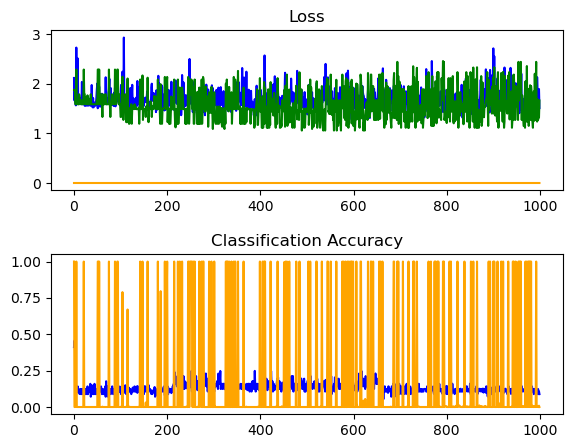

In [32]:
# learning curves
# plot diagnostic learning curves

import sys
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# plot loss
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history_student.history['student_loss'], color='blue', label='train')
pyplot.plot(history_student.history['distillation_loss'], color='orange', label='train')
pyplot.plot(history_student.history['val_student_loss'], color='green', label='validation')
# plot accuracy
pyplot.subplot(212)
pyplot.title('Classification Accuracy')
pyplot.plot(history_student.history['categorical_accuracy'], color='blue', label='train')
pyplot.plot(history_student.history['val_categorical_accuracy'], color='orange', label='validation')

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

# save plot to file
filename = sys.argv[0].split('/')[-1]
pyplot.savefig('Knowledge_distillation_distiller_plot.png')
plt. show()
pyplot.close()

In [35]:
print('Qkeras binary quantised Student Model Accuracy with TA distillation')
distiller.evaluate(test_set, y_test)

Qkeras binary quantised Student Model Accuracy with TA distillation
18/18 [==============================] - 1s 34ms/step - categorical_accuracy: 0.9982 - student_loss: 2.0510


[0.9982331991195679, 1.8325635194778442]

18/18 [==============================] - 1s 47ms/step


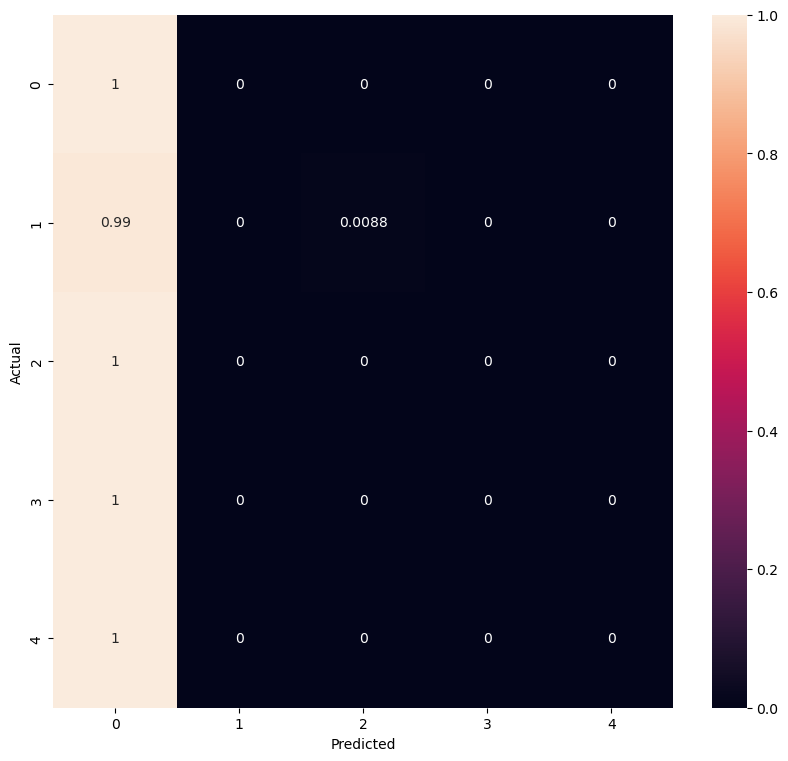

In [36]:
y_pred = student.predict(test_set)
y_pred_hard = np.argmax(y_pred, axis=1)
fig = plt.figure(figsize=(10,9))
cm = confusion_matrix(y_test, y_pred_hard, normalize='true')
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()